In [24]:
%matplotlib notebook

import matplotlib as mpl
from MalardClient.MalardClient import MalardClient
from MalardClient.DataSet import DataSet
from MalardClient.BoundingBox import BoundingBox
import datetime
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import os
import numpy as np
import pandas as  pd
import json
import math
from pandas.io.json import json_normalize
from matplotlib.colors import LinearSegmentedColormap

from datetime import datetime

In [25]:

ds = DataSet('cryotempo', 'GRIS_BaselineC_Q2', 'greenland')
#ds = DataSet('cryotempo', 'AntarcticaV2b', 'antarctic')

runName='test'
size = 100000

client = MalardClient()

bbox = client.boundingBox( ds )

print(bbox)

minX=-700000, maxX=900000, minY=-3400000, maxY=-600000, minT=2011-02-01 05:16:06, maxT=2016-06-30 16:15:42 N=4986781805


In [32]:

from MalardClient.MaskFilter import MaskFilter


minT = datetime(2011,2,1,0,0,0)
maxT = datetime(2018,6,30,23,59,59) 

maskFilterIce = MaskFilter( p_shapeFile="/data/puma1/scratch/cryotempo/masks/icesheets.shp"  ) 
maskFilterLRM = MaskFilter( p_shapeFile="/data/puma1/scratch/cryotempo/sarinmasks/LRM_Greenland.shp" , p_includeWithin=False ) 
#maskFilterSARIN = MaskFilter( p_shapeFile="/data/puma1/scratch/cryotempo/sarinmasks/SARIN_Greenland.shp" , p_includeWithin=True ) 

gcs = client.gridCellsWithinPolygon(ds, minT, maxT, extentFilter=maskFilterIce, maskFilters=[maskFilterLRM] )

###Jakobshavn bbox
minX=-262187
maxX=-93976
minY=-2386746
maxY=-2144979

wkt = "POLYGON (( {} {}, {} {}, {} {}, {} {}, {} {}))".format( minX,minY,minX,maxY,maxX,maxY,maxX,minY,minX,minY )

maskFilter = MaskFilter( p_wkt=wkt )

#gcs = client.gridCellsWithinPolygon(ds, minT, maxT, maskFilter )

print(len(gcs))

192


In [33]:
# background layers (must be same projection)
#rivers = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/rivers_reprojected.shp")
countries = gp.read_file("/data/puma1/scratch/cryotempo/masks/ice.shp")

In [34]:
# OPTION 2 (display as squares)
# convert to polygons
crs = client.getProjection(ds).proj4
print(crs)
def toGeoData(data):
    #data.drop(['geometry'], axis=1)
    geometry = []
    totals = []
    for gc in data:
        bb = gc
        geometry.append(Polygon([(bb.minX,bb.minY), (bb.minX,bb.maxY), (bb.maxX,bb.maxY), (bb.maxX,bb.minY), (bb.minX,bb.minY)]))
        totals.append(bb.numberOfPoints)
        
        
    df = pd.DataFrame()
    df['TotalPoints'] = totals
    
    gData = gp.GeoDataFrame(df, crs=crs, geometry=geometry)
    
      
    return gData

dfPolys = toGeoData(gcs)

+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs


<IPython.core.display.Javascript object>


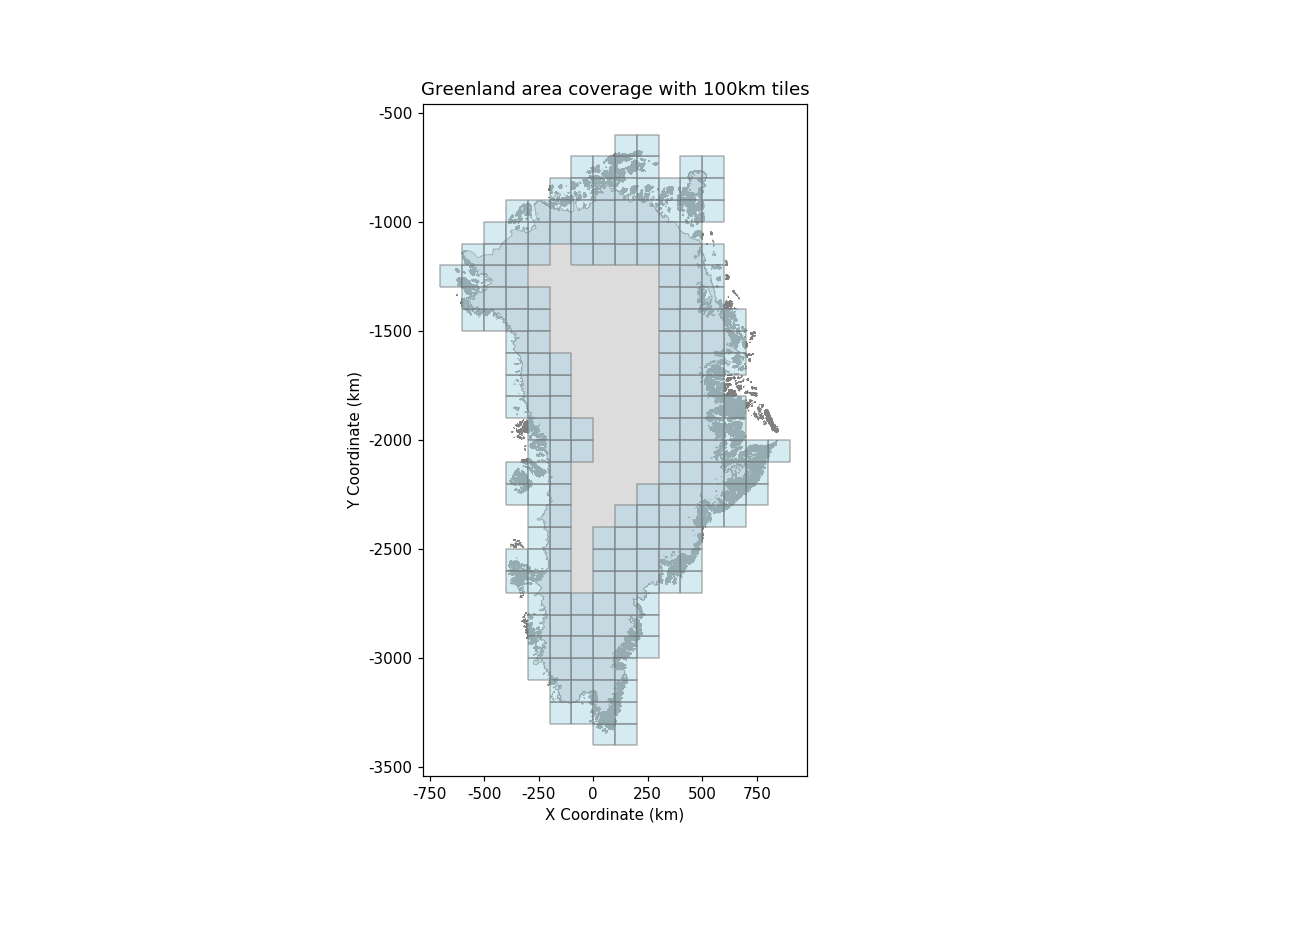

In [35]:
# OPTION 2: plot
%matplotlib notebook

# plot figure
fig, ax = plt.subplots(figsize=(11,8))

# plot background
countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
#rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)

# marker size
markersize = 1 #dfPoints['statistics.GlacierMaskArea.pointsize']

# min and max of colour scheme (change this!)

totals = [ gc.numberOfPoints for gc in gcs ]

diff = max(totals) - min(totals)
vmin= min(totals) #+ diff*0.25
vmax= max(totals)# - diff*0.25

#vmin = 6500000
#vmax = 7000000

# color scheme
cm = 'plasma'

# plot data
#dfPolys.plot(ax=ax, column='TotalPoints', vmin=vmin, \
#                     vmax=vmax, cmap=cm, alpha=0.8)
dfPolys.plot(ax=ax, column='TotalPoints',color='lightblue',edgecolor='dimgray', alpha=0.5)

# add colorbar with label
#bar=fig.colorbar(mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
#bar.set_label('Total number of points')

# add plot title
plt.title('Greenland area coverage with 100km tiles')
ax.set_xlabel("X Coordinate (km)")
ax.set_ylabel("Y Coordinate (km)")

def format_func(value, tick_number):
    return "{}".format(int(value/1000))
    

    
        
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
#r = np.arange(-500000, bbox.maxX, 500000)
#ax.set_xticks(r)



In [ ]:



crs = client.getProjection(ds).proj4

def toGeoData(data):
    #data.drop(['geometry'], axis=1)
    geometry = []
    totals = []
    for d in data:

        geometry.append(Point(d['x'],d['y']))
        totals.append(bb.numberOfPoints)
        
        
    df = pd.DataFrame()
    df['TotalPoints'] = totals
    
    gData = gp.GeoDataFrame(df, crs=crs, geometry=geometry)
    
      
    return gData

dfPolys = toGeoData(gcs)

In [36]:
fig.savefig("plots/greenland_v2.png")